# Сеть фитнес-центров «Культурист-датасаентист»

Задачи:
- спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:<ol>
    <li>выделить целевые группы клиентов;</li>
    <li>предложить меры по снижению оттока;</li>
    <li>определить другие особенности взаимодействия с клиентами.</li>

### Содержание <a id='toc'>

[1. Загрузка данных](#1)<br>
[2. Исследовательский анализ данных (EDA)](#2)<br>
[3. Модель прогнозирования оттока пользователей](#3)<br>
[4. Кластеризация пользователей](#4)<br>
[5. Выводы и базовые рекомендации по работе с клиентами](#5)

### 1. Загрузка данных <a id='1'>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
club = pd.read_csv('dataset/gym_churn.csv')

In [3]:
club.shape

(4000, 14)

В представленной базе 4000 записей.

In [4]:
club.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

В информационной таблице пропусков и искажений по типам данных не наблюдается.

In [5]:
club.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


<div style="border:solid black 1px; padding: 20px">
<b><i>gender</i></b> — пол<br>
<b><i>Near_Location</i></b> — проживание или работа в районе, где находится фитнес-центр<br>
<b><i>Partner</i></b> — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
<b><i>Promo_friends</i></b> — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)<br>
<b><i>Phone</i></b> — наличие контактного телефона<br>
<b><i>Contract_period</i></b> — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)<br>
<b><i>Group_visits</i></b> — факт посещения групповых занятий<br>
<b><i>Age</i></b> — возраст<br>
<b><i>Avg_additional_charges_total</i></b> — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон<br>
<b><i>Month_to_end_contract</i></b> — срок до окончания текущего действующего абонемента (в месяцах)<br>
<b><i>Lifetime</i></b> — время с момента первого обращения в фитнес-центр (в месяцах)
Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента<br>
<b><i>Avg_class_frequency_total</i></b> — средняя частота посещений в неделю за все время с начала действия абонемента<br>
<b><i>Avg_class_frequency_current_month</i></b> — средняя частота посещений в неделю за предыдущий месяц<br>
    
<b><i>Churn</i></b> — факт оттока в текущем месяце

</div>

[К содержанию](#toc)

### 2. Исследовательский анализ данных (EDA) <a id='2'>

Рассмотрим средние значения по всему датафрейму:

In [6]:
club.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Разделим на группы оставшихся и ушедших клиентов и сравним средние значения:

In [7]:
club.groupby('Churn').mean().reset_index()

,Churn,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
0,0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


На данном этапе можно предварительно выделить различия по признакам: 
- Partner(сотрудник-партнёр) - отток меньше
- Promo_friends (от знакомого) - отток меньше
- Contract_period (длительность абонемента) - на длинных абонементах ожидаемо отток меньше
- Group_visits (посещение групповых занятий) - люди сильнее вовлечены в жизнь клуба, отток меньше у посещающих
- Age (возраст клиента) - не сильно но влияет, очевидно чем старше человек, тем сильнее привязанность
- Avg_additional_charges_total (выручка по доп.услугам) - очевидно выше, если человек охотнее проводит время в клубе
- Month_to_end_contract - как следствие Contract_period, тут люди намерено не планировали долго задерживаться
- Lifetime - показывает так же намерения клиентов

Стравним гистограммы тех кто остался (Churn=0) и тех кто "оттек" (Churn=1):

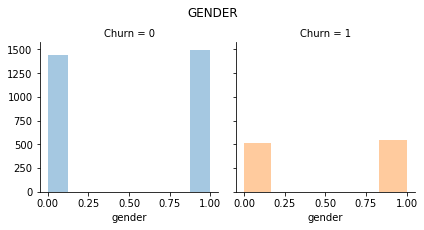

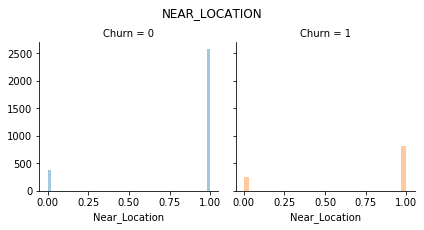

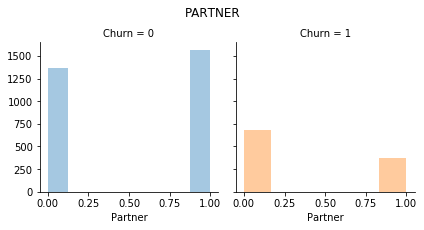

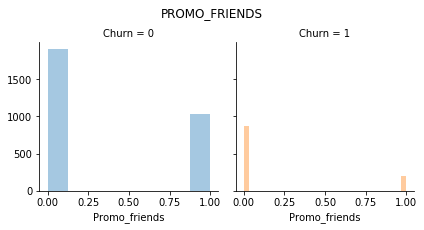

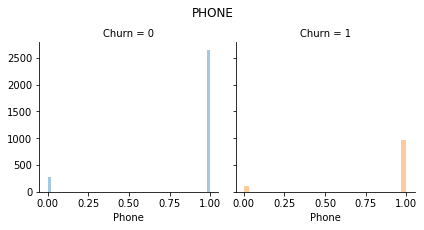

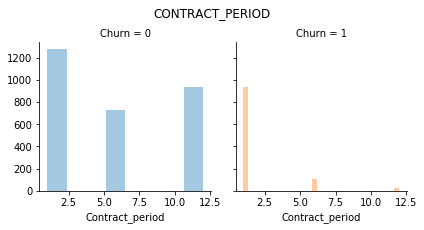

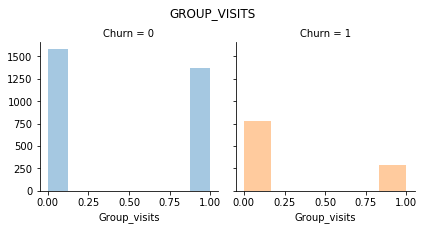

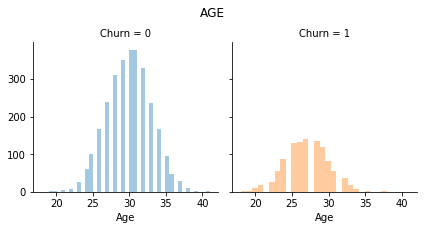

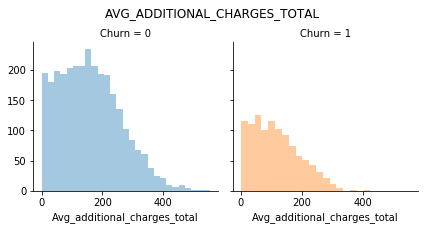

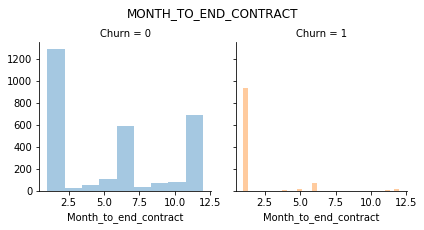

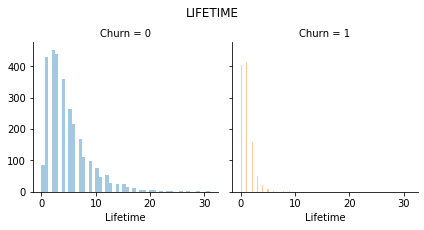

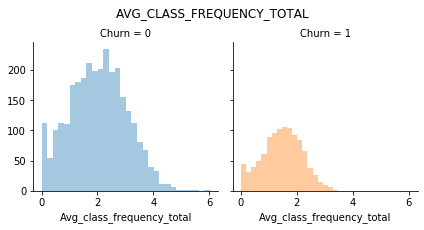

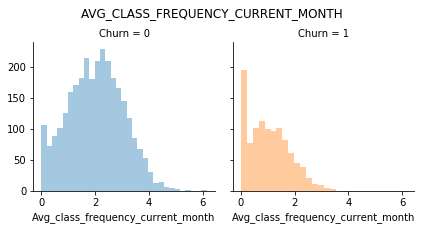

In [8]:
for col in club.drop('Churn', axis = 1).columns:
    g = sns.FacetGrid(club, col='Churn', hue='Churn')
    g = (g.map(sns.distplot, col, kde=False))
    g = g.fig.suptitle(col.upper(), y=1.05)

Исследование графика распределения оттока относительно признаков имеет мало смысла, так как в дискретном виде будут представлены все 4 варианта или распределение между ними.

Построим матрицу корреляций и тепловую карту корреляций:

In [9]:
club_cm = club.corr()

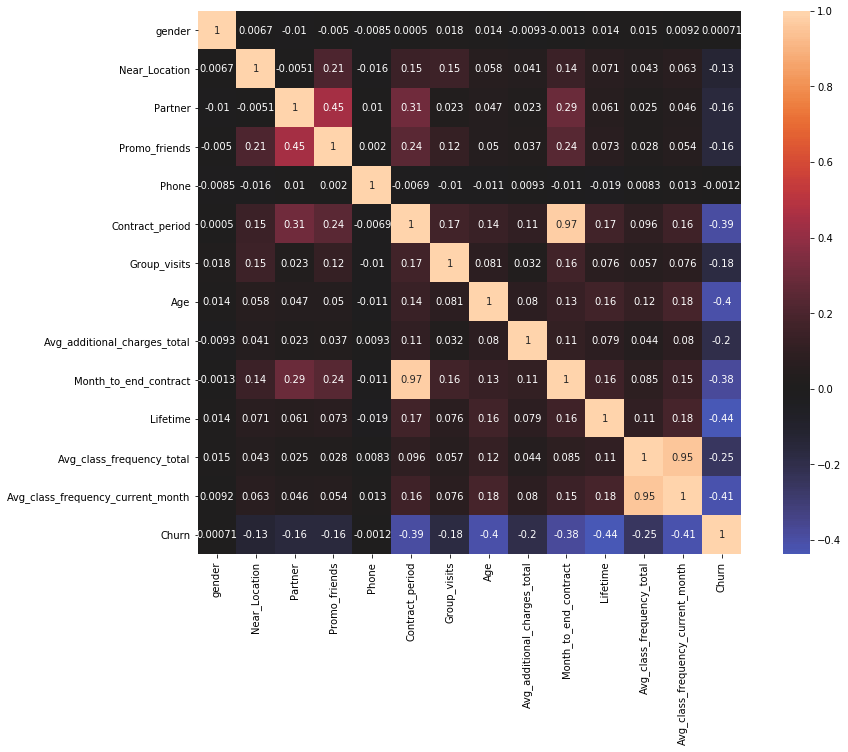

In [10]:
plt.subplots(figsize=(15,10))
sns.heatmap(club_cm, annot=True, square=True, center=0);

Очевидно, что коррелируют признаки, которые являются производными один от другого.
Отметим следующие зависимости:
- периода контракта с количеством месяцев до окончания контракта
- средение посещения в неделю за последний месяц и за весь период
- пришедших по партнерской программе и программа "приведи друга"
- количество оттекших пользователей и их lifetime, возраст, период контракта, месяцев до завершения, среднее количество посещений в неделю за последний месяц.
Конечно выводы нельзя делать только по матрице корреляций и распределениям, однако эти зависимости похожи на реалистичные.

[К содержанию](#toc)

### 3. Модель прогнозирования оттока пользователей <a id='3'>

Зададим матрицу признаков и целевую переменную:

In [11]:
X = club.drop(['Churn'], axis=1)
y = club['Churn']

Разделим данные на обучающую и валидационную выборку:

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Произведем стандартизацию величин:

In [13]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

Произведем обучение моделей двумя способами.

Логистическая регрессия:

In [14]:
lr_model = LogisticRegression()
lr_model.fit(X_train_st, y_train)
lr_y_pred = lr_model.predict(X_test_st)

Случайный лес:

In [15]:
rf_model = RandomForestClassifier(n_estimators = 100)
rf_model.fit(X_train_st, y_train)
rf_y_pred = rf_model.predict(X_test_st)

Создадим функцию метрик:

In [16]:
def find_metrics(test, pred):
    print('\tAccuracy: {:.2f}'.format(accuracy_score(test, pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(test, pred)))
    print('\tRecall: {:.2f}'.format(recall_score(test, pred)))

Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке.

Оценка предсказаний логистической регрессии:

In [17]:
find_metrics(y_test, lr_y_pred)

	Accuracy: 0.93
	Precision: 0.87
	Recall: 0.87


Оценка предсказаний случайного леса:

In [18]:
find_metrics(y_test, rf_y_pred)

	Accuracy: 0.92
	Precision: 0.86
	Recall: 0.83


*Accuracy* - доля правильных ответов:
- Здесь немного лучше показала себя логистическая регрессия

*Precision* - точность срабатываний:
- Здесь немого впереди случайный лес

*Recall* - полнота:
- Здесь снова логистическая регрессия и отрывом в 5%.

В целом получается что логистическая регрессия показала себя немного лучше на основании метрик. Но нужно отметить что эта модель сильнее "перестраховывается".

[К содержанию](#toc)

### 4. Кластеризация пользователей <a id='4'>

Произведем обязательную стандартизацию:

In [19]:
sc = StandardScaler()
club_sc = sc.fit_transform(club)

Построим матрицу расстояний функции:

In [20]:
link = linkage(club_sc, method='ward')

Отрисуем дендрограмму:

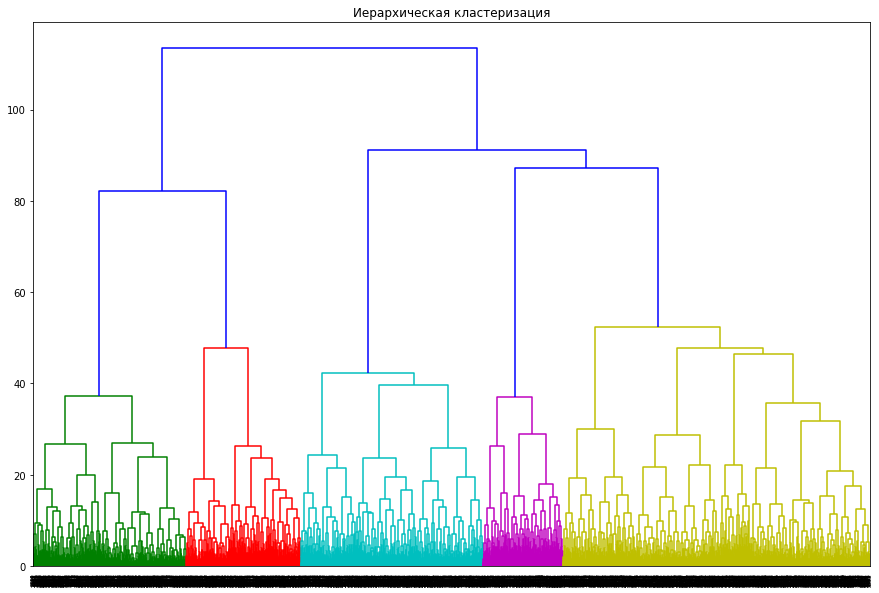

In [21]:
plt.figure(figsize=(15,10))
dendrogram(link, orientation='top')
plt.title('Иерархическая кластеризация');

Разделим набор на 5 кластеров.

Обучим модель кластеризации на алгоритме K-Means:

In [22]:
km_club = KMeans(n_clusters = 5)

Спрогнозируем кластеры:

In [23]:
labels = km_club.fit_predict(club)

Сохраним полученные метки в датасет:

In [24]:
club['clusters'] = labels

Средние значения признаков для кластеров:

In [25]:
club_mean = club.groupby('clusters').mean().reset_index()
club_mean

,clusters,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,0,0.515595,0.839181,0.451267,0.280702,0.898635,4.295322,0.407407,28.980507,106.035322,3.991228,3.538012,1.852004,1.708553,0.334308
1,1,0.468635,0.856089,0.516605,0.332103,0.926199,5.822878,0.431734,29.845018,356.481960,5.383764,4.420664,2.019260,2.009382,0.044280
2,2,0.507246,0.825121,0.488889,0.292754,0.907246,4.204831,0.387440,28.902415,35.702957,3.860870,3.400966,1.837356,1.692399,0.349758
3,3,0.511435,0.844075,0.495842,0.320166,0.902287,4.755717,0.423077,29.401247,174.873445,4.376299,3.749480,1.895200,1.785569,0.226611
4,4,0.521246,0.881020,0.511331,0.347025,0.898017,5.400850,0.433428,29.344193,250.984767,5.001416,4.169972,1.903480,1.843255,0.178470


Бросается в глаза характеристика:<br>**Avg_additional_charges_total** — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.<br>

Можно выделить **кластер #4** - в этом кластере в среднем все клиенты берут контракт на 6 месяцев, оставляют большие суммы на дополнительные услуги. Похоже что это кластер самых преданных клиентов клуба. В этом кластере самый маленький отток (в среднем 4%).

Следом идет **кластер #2** с чуть менее слабыми показателями, но тем не менее это достаточно активные пользователи услуг клуба, которые однако в отток попадают чаще (в среднем 17% оттока). При этом здесь находится в среднем 50% клиентов по партнерской программе. А за партнерской программой как мы заметили танется и акция "Пригласи друга".

Построим распределение признаков для кластеров:

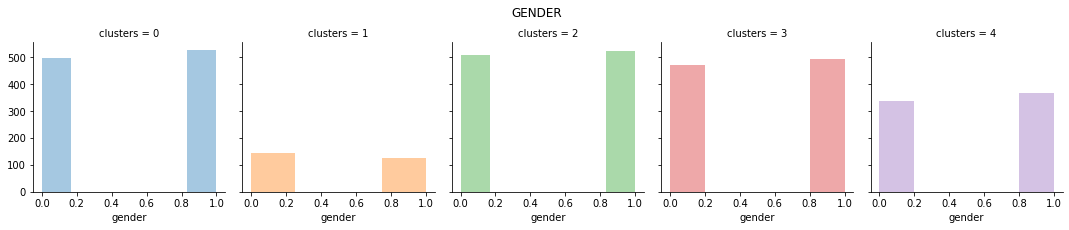

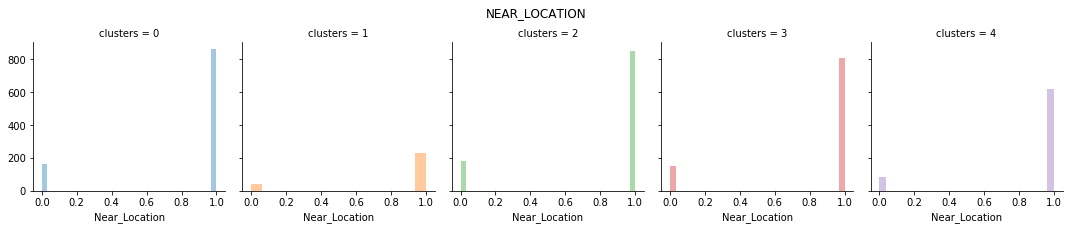

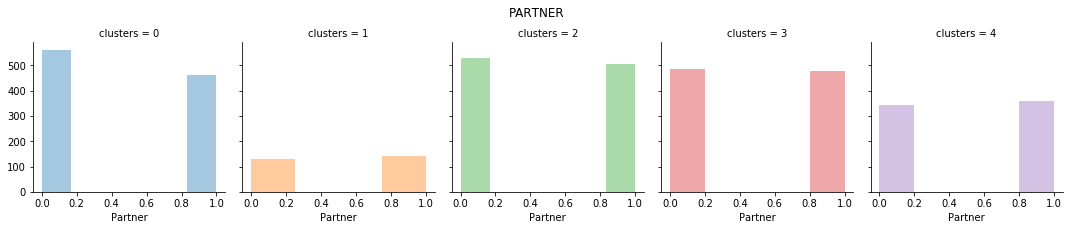

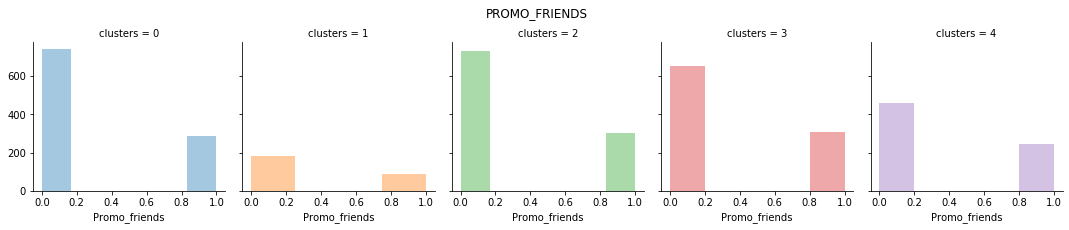

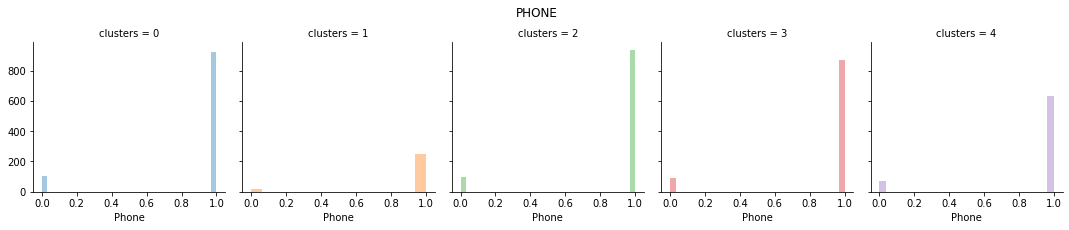

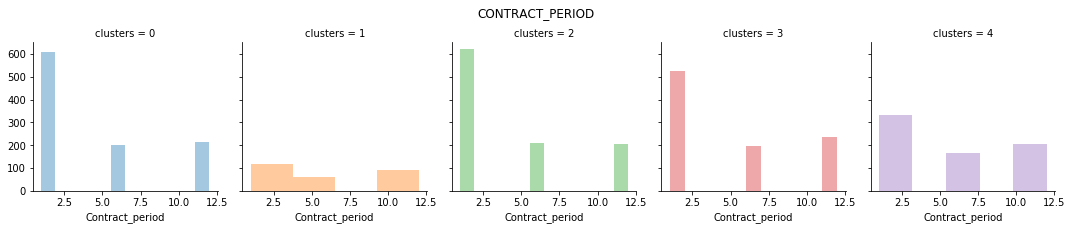

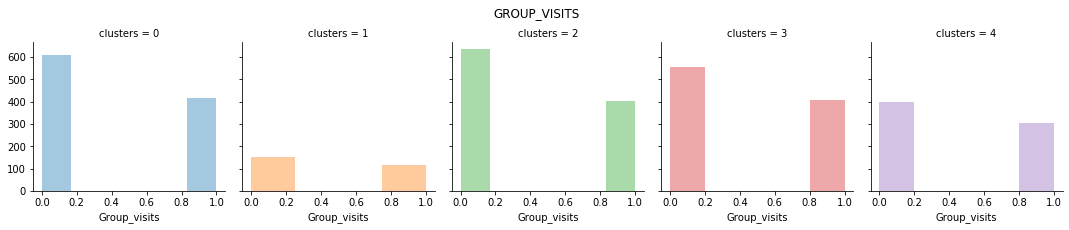

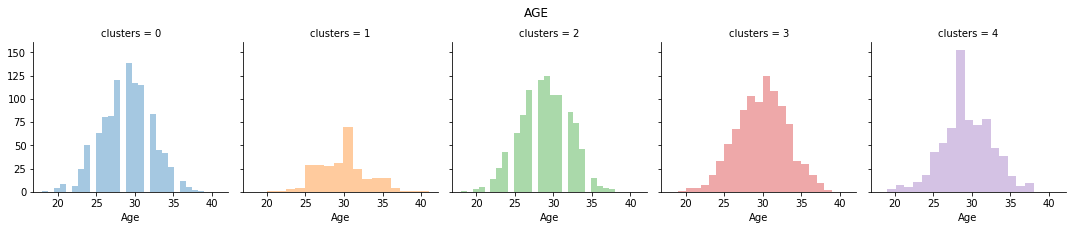

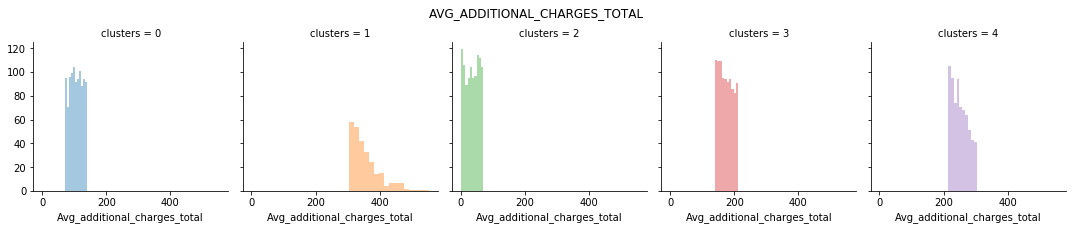

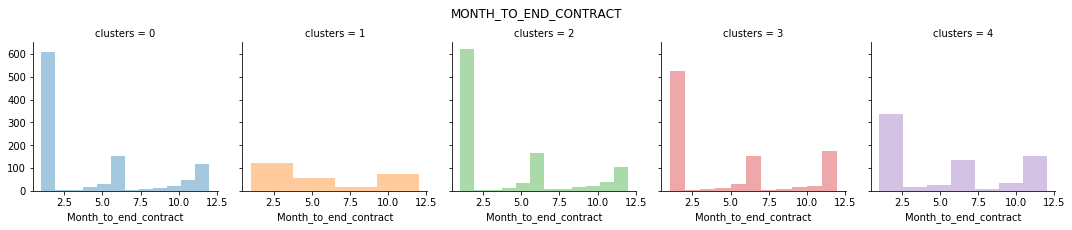

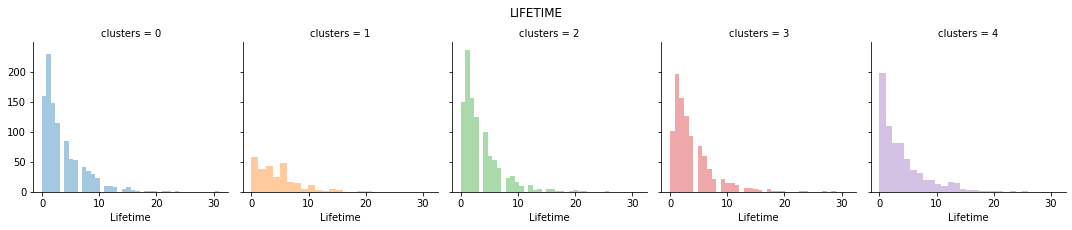

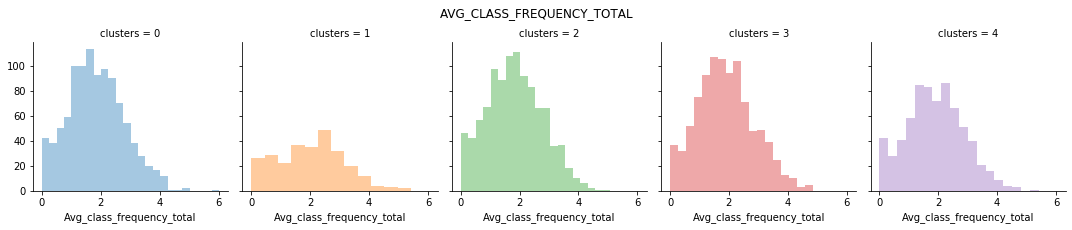

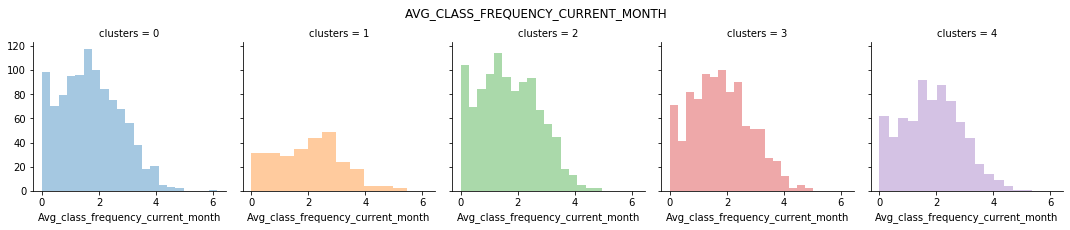

In [26]:
for col in club.drop(['Churn','clusters'], axis = 1).columns:
    k = sns.FacetGrid(club, col='clusters', hue='clusters')
    k = (k.map(sns.distplot, col, kde=False))
    k = k.fig.suptitle(col.upper(), y=1.05)

По графикам распределения можно предположить что кластеры распределяются главным образом по размеру выручки от дополнительных услуг.

In [27]:
club_mean.sort_values(by='Avg_additional_charges_total', ascending=False).loc[:,['clusters','Avg_additional_charges_total']]

,clusters,Avg_additional_charges_total
1,1,356.481960
4,4,250.984767
3,3,174.873445
0,0,106.035322
2,2,35.702957


Посчитаем долю оттока для каждого кластера:

In [28]:
club.groupby('clusters').agg({'Churn':'mean'}).sort_values(by='Churn')

,Churn
clusters,
1,0.044280
4,0.178470
3,0.226611
0,0.334308
2,0.349758


По доле оттока самым преданным клубу оказался кластер #4 с долей в 4%, а самым оттекаемым оказался кастер #0 c долей оттока в 35%.

[К сожержанию](#toc)

### 5. Выводы и базовые рекомендации по работе с клиентами <a id='5'>

По результатам исследования можно порекомендовать:
- рассмотреть клиентов, вошедших в каждый кластер более детально;
- активнее развивать источники нецелевого дохода клуба (кафе, спорт-товары, косметический и массажный салон);
- рассмотреть систему скидок и членских условий для разных кластеров пользователей (например, кластеру типа #4 предложить долгосрочные продукты, длительные персональные тренировки, можно подумать о дополнительных абонементах)
- продумать "быстрые" услуги для кластера типа #0;
- отдельно выделим кластер типа #2, здесь стоит продолжать вести партнерскую программу и вероятно развить еще сильнее членство в клубе, поскольку, стало заметно, что партнерская программа частично тянет за собой акцию "Приведи друга".

[К содержанию](#toc)